# 2.自然语言和单词的分布式表示

## 2.1 什么是自然语言处理

## 2.2 同义词词典

## 2.3 基于计数的方法

In [1]:
# 基于Python语料库的预处理
text = "You say goodbye and I say Hello."
text = text.lower()
text = text.replace('.', ' .')
print("text: ", text)
words = text.split(' ')
print("word: ", words)

text:  you say goodbye and i say hello .
word:  ['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [2]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
        
print("word_to_id: ", word_to_id)
print("id_to_word: ", id_to_word)

import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
print("corpus: ", corpus)

word_to_id:  {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
id_to_word:  {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
corpus:  [0 1 2 3 4 1 5 6]


In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

preprocess(text)

(array([0, 1, 2, 3, 4, 1, 5, 6, 7]),
 {'you': 0,
  'say': 1,
  'goodbye': 2,
  'and': 3,
  'i': 4,
  'hello': 5,
  '': 6,
  '.': 7},
 {0: 'you',
  1: 'say',
  2: 'goodbye',
  3: 'and',
  4: 'i',
  5: 'hello',
  6: '',
  7: '.'})

In [24]:
# 单词的分布式表示
# 共现矩阵
def create_co_matrix(corpus, vocab_size, window_size = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx ,word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - 1
            right_idx = idx + 1
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
        
    return co_matrix
vocab_size = len(word_to_id)
corpus = preprocess(text)[0]
create_co_matrix(corpus, vocab_size)

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [14]:
# 向量间的相似度
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x**2)) # x的正规化
    ny = y / np.sqrt(np.sum(y**2)) # y的正规化
    return np.dot(nx, ny)

def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps) # x的正规化
    ny = y / (np.sqrt(np.sum(y**2)) + eps) # y的正规化
    return np.dot(nx, ny)

In [22]:
x = np.array([1,2,34,4,2])
y = np.array([1,2,99,4,2])
cos_similarity(x, y)

0.9954385623722085

In [25]:
text = "You say goodbye and I say Hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
c0 = C[word_to_id['you']] # you的单词向量
c1 = C[word_to_id['i']] # i的单词向量
print(cos_similarity(c0, c1))

0.7071067691154799


In [26]:
# 相似单词的排序
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 取出查询词
    if query not in word_to_id:
        print("%s is not found" % query)
        return
    print("\n[query]" + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 计算余弦相似度
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 基于余弦相似度，按降序输出值
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(" %s: %s" % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [27]:
import sys
sys.path.append("..")

text = "You say goodbye and I say Hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query]you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 2.4 基于计数方法的改进

In [30]:
# 点互信息 （PMI）
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
        
            if verbose:
                cnt += 1
                if cnt % (total//100+1) == 0:
                    print('%.1f%% done ' % (100*cnt/total))
    return M

In [31]:
import sys
sys.path.append("..")
import numpy as np

text = "You say goodbye and I say Hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 有效位数为3位
print("covariance matrix")
print(C)
print("-"*50)
print("PPMI")
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


C[0] =  [0 1 0 0 0 0 0]
W[0] =  [0.    1.807 0.    0.    0.    0.    0.   ]
U[0] =  [-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]
U[0, :2] =  [-3.409e-01 -1.110e-16]


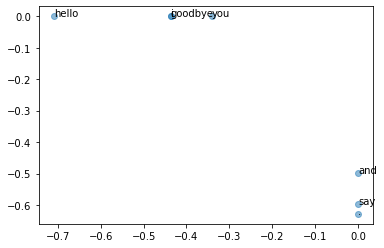

In [32]:
# 降维
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt

text = "You say goodbye and I say Hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)
print("C[0] = ", C[0]) # 共现矩阵
print("W[0] = ", W[0]) # PPMI矩阵
print("U[0] = ", U[0]) # SVD矩阵 
print("U[0, :2] = ", U[0, :2]) # SVD降至二维后向量

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [34]:
# PTB数据集
import sys
sys.path.append("..")
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]', id_to_word[0])
print('id_to_word[1]', id_to_word[1])
print('id_to_word[2]', id_to_word[2])
print()
print("word_to_id['car']", word_to_id['car'])
print("word_to_id['happy']", word_to_id['happy'])
print("word_to_id['lexus']", word_to_id['lexus'])

corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0] aer
id_to_word[1] banknote
id_to_word[2] berlitz

word_to_id['car'] 3856
word_to_id['happy'] 4428
word_to_id['lexus'] 7426


In [76]:
# 基于PTB数据集的评价
import sys
sys.path.append("..")
import numpy as np
from dataset import ptb
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting co-occurrence...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('caculating PPMI...')
W = ppmi(C, verbose=True)

print('caculating SVD...')
try:
    # truncated SVD(fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    # SVD(slow)
    pass
#     U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting co-occurrence...
caculating PPMI...
1.0% done 
2.0% done 
3.0% done 
4.0% done 
5.0% done 
6.0% done 
7.0% done 
8.0% done 
9.0% done 
10.0% done 
11.0% done 
12.0% done 
13.0% done 
14.0% done 
15.0% done 
16.0% done 
17.0% done 
18.0% done 
19.0% done 
20.0% done 
21.0% done 
22.0% done 
23.0% done 
24.0% done 
25.0% done 
26.0% done 
27.0% done 
28.0% done 
29.0% done 
30.0% done 
31.0% done 
32.0% done 
33.0% done 
34.0% done 
35.0% done 
36.0% done 
37.0% done 
38.0% done 
39.0% done 
40.0% done 
41.0% done 
42.0% done 
43.0% done 
44.0% done 
45.0% done 
46.0% done 
47.0% done 
48.0% done 
49.0% done 
50.0% done 
51.0% done 
52.0% done 
53.0% done 
54.0% done 
55.0% done 
56.0% done 
57.0% done 
58.0% done 
59.0% done 
60.0% done 
61.0% done 
62.0% done 
63.0% done 
64.0% done 
65.0% done 
66.0% done 
67.0% done 
68.0% done 
69.0% done 
70.0% done 
71.0% done 
72.0% done 
73.0% done 
74.0% done 
75.0% done 
76.0% done 
77.0% done 
78.0% done 
79.0% done 
80.0% done 
81.0